### 1.Create Label

In [1]:
import pandas as pd
from pathlib import Path

current_dir = Path.cwd()
df = pd.read_csv(current_dir.parent/ "outputs" /"classification" / "merged_college_stats.csv")
df.head()

,SEASON,OVERALL_PICK,Totals_FG,Totals_FT,Totals_TRB,Totals_BLK,Totals_STL,Totals_TOV,Totals_PF,Shooting_FG%,MP
0,2000,1,221.0,141.0,300.0,107.0,43.0,56.0,71.0,0.568,909.0
1,2000,2,208.0,127.0,279.0,95.0,50.0,80.0,88.0,0.608,1013.0
2,2000,4,327.0,175.0,285.0,39.0,29.0,77.0,103.0,0.582,1243.0
3,2000,5,175.0,124.0,243.0,15.0,46.0,71.0,70.0,0.476,1058.0
4,2000,6,140.0,70.0,123.0,30.0,31.0,46.0,64.0,0.478,879.0


In [3]:
import numpy as np
import pandas as pd

# df is your merged dataset
# drafted = 1 if picked 1–60, undrafted (100) = 0
df["drafted"] = (df["OVERALL_PICK"] <= 60).astype(int)
print(df["drafted"].value_counts())


drafted
1    1210
0     552
Name: count, dtype: int64


### 2. Train Test Split

In [4]:
# Make sure Season is numeric or sortable
max_season = df["SEASON"].max()
train_df = df[df["SEASON"] < max_season].copy()
test_df  = df[df["SEASON"] == max_season].copy()

print("Train seasons:", sorted(train_df["SEASON"].unique()))
print("Test season:", max_season)
print("Train size:", len(train_df), "Test size:", len(test_df))


Train seasons: [np.int64(2000), np.int64(2001), np.int64(2002), np.int64(2003), np.int64(2004), np.int64(2005), np.int64(2006), np.int64(2007), np.int64(2008), np.int64(2009), np.int64(2010), np.int64(2011), np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024)]
Test season: 2025
Train size: 1686 Test size: 76


### 3. Define Feature and Target

In [5]:
from sklearn.model_selection import train_test_split

# Columns you DO NOT want as features
cols_to_drop = [
    "OVERALL_PICK",      # target used for ranking
    "drafted",           # our new classification label
    "SEASON",            # leak / grouping
    "draft_year",        # if present and redundant with Season
    "player_name",       # or "PLAYER", "Player", etc.  ### CHANGE IF NEEDED
]

cols_to_drop = [c for c in cols_to_drop if c in train_df.columns]

X_train = train_df.drop(columns=cols_to_drop)
y_train = train_df["drafted"]

X_test  = test_df.drop(columns=cols_to_drop)
y_test  = test_df["drafted"]

print("Feature shape:", X_train.shape, X_test.shape)


Feature shape: (1686, 9) (76, 9)


### 4. Train

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier

numeric_cols = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols     = X_train.select_dtypes(include=["object", "category"]).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

clf = GradientBoostingClassifier(
    random_state=42
)

model_clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("clf", clf),
])


In [7]:
model_clf.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['Totals_FG', 'Totals_FT',
                                                   'Totals_TRB', 'Totals_BLK',
                                                   'Totals_STL', 'Totals_TOV',
                                                   'Totals_PF', 'Shooting_FG%',
                                                   'MP']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  [])])),
                ('clf', GradientBoostingClassifier(random_state=42))])

### 5.Evaluate

Confusion matrix:
 [[ 1 12]
 [ 5 58]]

Classification report:

              precision    recall  f1-score   support

           0      0.167     0.077     0.105        13
           1      0.829     0.921     0.872        63

    accuracy                          0.776        76
   macro avg      0.498     0.499     0.489        76
weighted avg      0.715     0.776     0.741        76

ROC-AUC: 0.5213675213675213


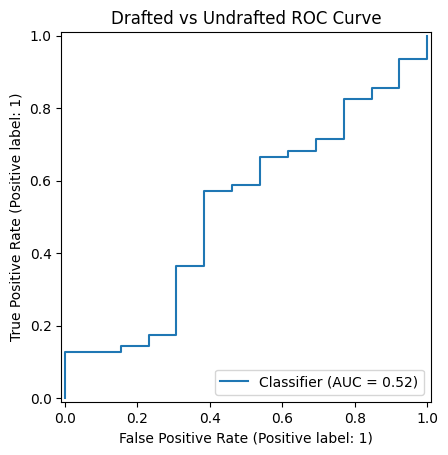

In [8]:
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    RocCurveDisplay,
)

# Predicted class labels (0/1)
y_pred = model_clf.predict(X_test)

# Predicted probabilities for class 1 (drafted)
y_proba = model_clf.predict_proba(X_test)[:, 1]

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)

# Precision / recall / F1 / support
print("\nClassification report:\n")
print(classification_report(y_test, y_pred, digits=3))

# ROC-AUC
roc_auc = roc_auc_score(y_test, y_proba)
print("ROC-AUC:", roc_auc)

# Optional: plot ROC curve (if you're in a notebook)
import matplotlib.pyplot as plt

RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("Drafted vs Undrafted ROC Curve")
plt.show()


### 6.Optional Tweak

In [9]:
threshold = 0.3  # more players predicted as drafted

y_pred_custom = (y_proba >= threshold).astype(int)

cm_custom = confusion_matrix(y_test, y_pred_custom)
print("Confusion matrix (threshold=0.3):\n", cm_custom)

print("\nClassification report (threshold=0.3):\n")
print(classification_report(y_test, y_pred_custom, digits=3))


Confusion matrix (threshold=0.3):
 [[ 0 13]
 [ 0 63]]

Classification report (threshold=0.3):

              precision    recall  f1-score   support

           0      0.000     0.000     0.000        13
           1      0.829     1.000     0.906        63

    accuracy                          0.829        76
   macro avg      0.414     0.500     0.453        76
weighted avg      0.687     0.829     0.751        76



/Users/tenzin/Desktop/mycodes/nba-draft-ranker/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tenzin/Desktop/mycodes/nba-draft-ranker/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tenzin/Desktop/mycodes/nba-draft-ranker/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.